# Introduction to Digital Forensincs - **Assignment 2**

By Beatrice Beretta (s2584891), Rodrigo Carvalho (s2379821), Alison Brandt (s2367815), Chris Bleeker (s2462648), Allen Sirkin (s2293153) and Julia Naastepad (s2483068)

## Introduction and motivation

The goal of this analysis is to gain a better understanding of how DDoS attacks are typically performed. This is done by inspecting a capture of all the packets being exchanged on a computer which is being attacked. We want to inspect what method is used (abused) to perform these attacks and how to detect these attacks in a stream of packets. Alongside that, we want to inspect what characteristics the attackers have in common. Combining this data, we gather the details from the provided attack and learn to detect this attack in the future.

## Methodology

To perform the analysis, we were given a list of questions to answer. These questions will be used as a baseline for the analysis, but we will allow ourselves to take some creative liberty at some points to, for example, visualize the results in a graph or make the results clearer in some other way.

To answer these questions, we will use this Jupyter notebook to generalize and automate the process. This is done by first converting the pcap file to a format `pandas` understands by using `tshark`, which is a tool that is included with Wireshark. After this, we can use Python to analyze and filter the results.

## Setup

### Import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Convert the pcap file to a CSV file that can be imported by pandas

In [3]:
# Mostly taken from https://github.com/jjsantanna/pcap_dns_ddos_analysis/blob/master/pcap_analysis_dsn_attack_example.ipynb
# You'll need tshark for the following command.
!tshark -n -r real_booter_attack.pcap -E separator=; -E header=y -T fields \
    -e frame.time_epoch \
    -e eth.src \
    -e ip.proto \
    -e ip.src \
    -e ip.dst \
    -e udp.srcport \
    -e udp.dstport \
    -e frame.len \
    -e dns.qry.type \
    > pcap.csv

tshark: The file "real_booter_attack.pcap" appears to have been cut short in the middle of a packet.


In [4]:
df = pd.read_csv('pcap.csv', sep = ';')

### Polish the data and show the structure

In [5]:
df['frame.time_epoch'] = pd.to_datetime(df['frame.time_epoch'], unit = 's')

In [6]:
df.head()

,frame.time_epoch,eth.src,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,frame.len,dns.qry.type
0,2014-12-22 15:38:42.525944832,06:90:f4:0e:e0:ff,1,162.8.125.17,172.31.28.132,NaN,NaN,62,NaN
1,2014-12-22 15:38:42.525981952,06:9a:6c:66:90:33,1,172.31.28.132,162.8.125.17,NaN,NaN,62,NaN
2,2014-12-22 15:38:42.648396032,06:9a:6c:66:90:33,17,172.31.28.132,172.31.0.2,51139.0,53.0,103,1.0
3,2014-12-22 15:38:42.648421888,06:9a:6c:66:90:33,17,172.31.28.132,172.31.0.2,51139.0,53.0,103,28.0
4,2014-12-22 15:38:42.648628992,06:90:f4:0e:e0:ff,17,172.31.0.2,172.31.28.132,53.0,51139.0,164,28.0


## Analysis

### How many records are in the entire trace?

In [7]:
len(df)

122233

### What is the duration of the entire trace?

In [8]:
duration = max(df['frame.time_epoch']) - min(df['frame.time_epoch'])
'{} seconds'.format(duration.total_seconds())

'25.343013 seconds'

### Some examples of packets which are *NOT* part of the attack

![Unrelated Packet #1](unrelated_packet_1.png)

This is a ping packet. Since the attack is executed using DNS reflection, this packet is not part of the attack, but just a ping request to the computer capturing these packets.

![Unrelated Packet #2](unrelated_packet_2.png)

While this is a DNS request packet, all the packets that are part of the attack are DNS response packets, since the way the attack works is that the victim does not need to send out DNS request themselves. This being a request packet thus excludes it from the attack.

![Unrelated Packet #3](unrelated_packet_3.png)

There seems to be a single TCP packet in the capture. Since all attack-related packets are DNS, which runs on UDP, this packet is not related to the attack, and is more likely a connection started before the capture that timed out, thus sending a RST packet, which closes the TCP connection.

### What are the characteristics of packets related to the attack?

In [9]:
target_ip = df['ip.dst'].value_counts().index[0]

In [10]:
# There are some requests that the victim issues, we want to exclude these from the attack packets.
request_ips = df[df['ip.proto'] == '17'][df['ip.src'] == target_ip]['ip.dst']

# Only show DNS packets.
attack_df = df[df['ip.proto'] == '17'][~df['dns.qry.type'].isnull()]
# Filter out the responses to manually requested DNS queries.
attack_df = attack_df[~attack_df['ip.src'].isin(request_ips)]
# Only show DNS responses to the victim.
attack_df = attack_df[attack_df['ip.dst'] == target_ip]

attack_df.head()

,frame.time_epoch,eth.src,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,frame.len,dns.qry.type
46,2014-12-22 15:38:47.712599040,06:90:f4:0e:e0:ff,17,89.228.8.86,172.31.28.132,53.0,80.0,3231,255.0
48,2014-12-22 15:38:47.713639936,06:90:f4:0e:e0:ff,17,89.228.8.86,172.31.28.132,53.0,80.0,3231,255.0
50,2014-12-22 15:38:47.716510976,06:90:f4:0e:e0:ff,17,89.228.8.86,172.31.28.132,53.0,80.0,3231,255.0
52,2014-12-22 15:38:47.718020864,06:90:f4:0e:e0:ff,17,89.228.8.86,172.31.28.132,53.0,80.0,3231,255.0
54,2014-12-22 15:38:47.723645952,06:90:f4:0e:e0:ff,17,89.228.8.86,172.31.28.132,53.0,80.0,3231,255.0


The wireshark filter for this specific attack would be `!icmp && dns && ip.dst == 172.31.28.132 && ip.src != 172.31.0.2`:
- We filter out the ICMP packets, as the victim's computer actually responds to some of the DNS responses. While these are a result of the attack, they are not actually part of the attack.
- Only show the packets with the destination set to the victim's computer.
- One IP actually sent DNS responses to our own requests, so we filter this one out.

### What is the target IP for the attack?

In [11]:
target_ip

'172.31.28.132'

### How many records are part of the attack?

In [12]:
len(attack_df)

120149

### How many unique IP addresses performed the attack?

In [13]:
len(attack_df['ip.src'].value_counts())

79

### Which source IP's sent the most packets in the attack?

<AxesSubplot:>

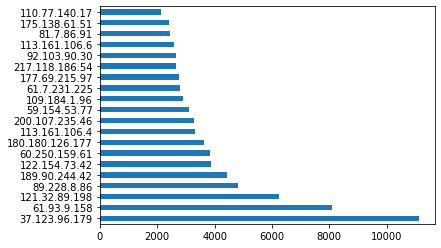

In [14]:
attack_df['ip.src'].value_counts()[:20].plot(kind = 'barh')

In [15]:
top3 = attack_df['ip.src'].value_counts()[:3]
top3

37.123.96.179    11126
61.93.9.158       8086
121.32.89.198     6261
Name: ip.src, dtype: int64

### Where are these top 3 IP's located and what Autonomous Systems are related?

In [16]:
import json
from urllib.request import urlopen

def ip_info(ip):
    response = urlopen('https://ipinfo.io/{}/json'.format(ip))
    data = json.load(response)
    return [ip, '{}, {}'.format(data['city'], data['country']), data['org']]

top3_list = list(map(ip_info, top3.keys()))
top3_info = pd.DataFrame(top3_list, columns = ['IP', 'Location', 'AS'])
top3_info

,IP,Location,AS
0,37.123.96.179,"İzmir, TR",AS57844 SPDNet Telekomunikasyon Hizmetleri Bil...
1,61.93.9.158,"Hong Kong, HK",AS9269 Hong Kong Broadband Network Ltd.
2,121.32.89.198,"Guangzhou, CN",AS4134 CHINANET-BACKBONE


### What is the distribution of vendors related to the source IP's of the attack?

For this we use the `mac-vendor-lookup` pip package. 

In [17]:
!pip install mac-vendor-lookup nest_asyncio > /dev/null

In [18]:
# Without this, async actions won't work in Jupyter.
import nest_asyncio
nest_asyncio.apply()

from mac_vendor_lookup import MacLookup
mac = MacLookup()

def get_vendor(m):
    try:
        return mac.lookup(m)
    except:
        return 'Unknown'

In [19]:
macs = pd.DataFrame(attack_df['eth.src'].value_counts())
macs.reset_index(inplace = True)
macs.rename(inplace = True, columns = { 'index': 'MAC address', 'eth.src': 'Count' })

macs['Vendor'] = macs['MAC address'].map(get_vendor)
macs

,MAC address,Count,Vendor
0,06:90:f4:0e:e0:ff,120149,Unknown


It seems that all the packets in the attack have the same source MAC address from an unknown vendor. It makes sense that they're all the same, as the MAC address is most likely the address of the router before the capturing computer, not from the actual packet sender.

### What are the source ports involved in the attack?

In [20]:
attack_df['udp.srcport'].value_counts()

53.0    120149
Name: udp.srcport, dtype: int64

All the packets from the attack are from port 53, which makes sense, because that is the default DNS port.

### How much was the data rate peak of the attack?

In [29]:
data_rate = attack_df[['frame.time_epoch', 'frame.len']]
data_rate['frame.time_epoch'] = data_rate['frame.time_epoch'].map(lambda t : t.round(freq = 'S'))
data_rate = data_rate.groupby(['frame.time_epoch']).sum()

peak_data_rate = data_rate.max()['frame.len']
'{:.2f} Mbits/s'.format(peak_data_rate / 1024 / 1024)

'13.44 Mbits/s'

### What is the distribution of TCP flags involvbed in the attack?

There aren't any TCP packets in the attack.

### What is the distribution of packet length?

2839    8473
554     4650
225     4132
3049    4051
2496    3960
        ... 
268        7
3931       6
4015       6
3656       5
70         2
Name: frame.len, Length: 240, dtype: int64

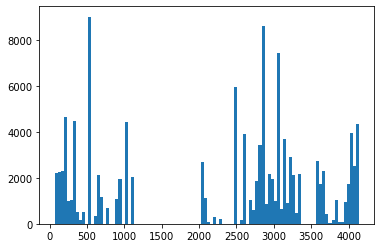

In [22]:
packet_lengths = attack_df['frame.len']
plt.hist(packet_lengths, bins = 100)
packet_lengths.value_counts()

There doesn't seem to be any clear distribution of packet lengths, but a lot concentrated around 500 bytes, and a lot around 3000 bytes in size.

## Conclusion

This attack is most likely a DNS reflection attack originating from China. We can see that about 80 IP's are used to send around 120,000 responses in 25 seconds, resulting in a pretty low but respectable 13 MBits/s network load. The top IP address sent about 10% of all requests, with the rest going down decreasingly. During the attack, basically no other packets were exchanged, but it's unclear wether this is due to the network being congested, or that the network intentionally wasn't used.

The attacking IP addresses don't have much in common. The top 3 IP addresses however all seem to be located in or around China. The attack is pretty easy to detect, as it's the same few hostnames in the DNS responses being responded again and again at a very quick pace. The hostnames seem to be selected partially based on response length, as more than half of the packets are more than 2KiB in size, but there is still a large portion that is under 1KiB in size.